<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/bt_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install
!pip install self_supervised
!pip install pytest
!pip install ipytest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 538 kB/s 
     |████████████████████████████████| 551 kB 48.5 MB/s 
     |████████████████████████████████| 548 kB 77.4 MB/s 
     |████████████████████████████████| 163 kB 84.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 44.8 MB/s 
     |████████████████████████████████| 1.6 MB 65.4 MB/s 
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: pytest
    Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [2]:
#import 
import fastai
import self_supervised
import torch
if torch.cuda.is_available():device='cuda'
else:device='cpu'
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm
from torchvision import transforms
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")

In [3]:
#In this cell we get the data for MNIST (including some helpful functions we can potentially use
#to get CIFAR10 data etc)
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
#Base functions / classes we need to train a BT / RBT model.






class RandomGaussianBlur(RandTransform):
    "Randomly apply gaussian blur with probability `p` with a value of s"
    order = 11
    def __init__(self, p=0.5, s=(8,32),s1=None, same_on_batch=False, **kwargs): 
        store_attr()
        super().__init__(p=p, **kwargs)
        
    def encodes(self, x:TensorImage):

        if isinstance(self.s, int):   s = (self.s,self.s)
        elif isinstance(self.s, tuple) or isinstance(self.s, list): s=self.s
     
        #Default for ImageNet from BYOL / BT papers
        if self.s1 is None:
            self.s1 = np.random.uniform(0.1,2)
            
        tfm = korniatfm.RandomGaussianBlur(kernel_size=s,sigma=(self.s1,self.s1),same_on_batch=self.same_on_batch,p=1.)
        return tfm(x)
    
def get_batch_augs(size,
                    rotate=True,
                    jitter=True,
                    bw=True,
                    blur=True,
                    solar=True,
                    resize_scale=(0.08, 1.0), #BYOL defaulta
                    resize_ratio=(3/4, 4/3), #BYOL defaults
                    rotate_deg=30,
                    jitter_s=.6,
                    blur_s=(4,32),
                    sol_t=0.05,
                    sol_a=0.05,
                    same_on_batch=False,
                    flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3,sol_p=0.1,
                    stats=imagenet_stats,
                    cuda=default_device().type == 'cuda',
                    xtra_tfms=[]):
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    
    korniatfm.RandomHorizontalFlip.order = RandomResizedCrop.order-1
    
    #Make backwards compatible for now, but eventually will remove this
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    
    tfms += [korniatfm.RandomHorizontalFlip(p=flip_p)]

    if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

                                             #brightness,contrast,saturation,hue
    if jitter: tfms += [korniatfm.ColorJitter(0.4*jitter_s, 0.4*jitter_s, 0.2*jitter_s, 0.1*jitter_s, p=jitter_p, same_on_batch=same_on_batch)]
    if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]
        
    
    if blur:   tfms += [RandomGaussianBlur(p=blur_p, s=blur_s, same_on_batch=same_on_batch)]

    korniatfm.RandomSolarize.order = RandomGaussianBlur.order + 1 #we want to apply solarization after RandomGaussianBlur
    
    if solar: tfms += [korniatfm.RandomSolarize(p=sol_p,thresholds=sol_t, additions=sol_a,same_on_batch=same_on_batch)]

    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms

    pipe = Pipeline(tfms, split_idx = 0)
    return pipe


@delegates(get_batch_augs)
def get_multi_aug_pipelines(size, **kwargs): return get_batch_augs(size, **kwargs)
    

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(size=size,**kwargs)



class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): 
        
        return self.projector(self.encoder(x))

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

# @delegates(get_multi_aug_pipelines)
# def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

def random_sinusoid(x,std=0.1,seed=0):
    
    seed_everything(seed=seed)    
    t=(std) * torch.randn(1,ps).to(device)
    s=(std) * torch.randn(1,ps).to(device)
    
    u=torch.randn(1,ps).to(device)
    v=torch.randn(1,ps).to(device)

    a=(0.2) * torch.randn(1,ps).to(device)
    b=(0.2) * torch.randn(1,ps).to(device)

    return a*torch.sin(t*x[:,]*math.pi+u) + b*torch.cos(s*x[:,]*math.pi+v)

def C_z1z2(z1norm,z1norm_2,z2norm,z2norm_2,bs,indep=False):
    
    if indep == False:
        C1 =  (z1norm.T @ z2norm_2) / bs
        C2 = (z1norm_2.T @ z2norm) / bs
        cdiff = (0.5*C1.pow(2) + 0.5*C2.pow(2))
        
    elif indep == True:
        cdiff =  (z1norm_2.T @ z2norm_2) / bs
        
    return cdiff

class Cdiff_Rand:
    
    def __init__(self,seed,bs,std=0.1,K=2):
        self.seed=seed
        self.std=std
        self.K=K
        self.bs=bs

    def __call__(self,z1norm,z2norm):
        
        cdiff_rand=0
        for i in range(self.K):

            z1norm_2,z2norm_2 = random_sinusoid(z1norm,std=self.std,seed=self.seed+i), random_sinusoid(z2norm,std=self.std,seed=2*self.seed+i)
            cdiff_rand = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs,indep=True)

        cdiff_rand=(1/self.K)*cdiff_rand
    
        return cdiff_rand

class Max_Corr(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(ps,ps)
        self.fc2 = nn.Linear(ps,ps)

        self.fc3 = nn.Linear(ps,ps)
        self.fc4 = nn.Linear(ps,ps)

        self.sigmoid = nn.Sigmoid()

        self.relu = nn.ReLU()
    def forward(self,x,y):

        x=self.sigmoid(self.fc1(x)) #when (sigmoid,relu) GREAT results, with (sigmoid,sigmoid) TERRIBLE. Currently testing (relu,relu)
        x=self.fc2(x)
       
        y=self.relu(self.fc3(y)) #originally had relu and got really good results. If we can't reproduce those results, possible reasons:
                                    #results were due to chance; or having relu on one branch (and sigmoid on the other) helps via breaking                                     #the symmetry! Other idea: set fc1=fc3, fc2=fc4. 
        y=self.fc4(y)

        return x,y

class Cdiff_Sup:
    
    def __init__(self,I,inner_steps,bs,indep):
        
        self.I=I
        self.inner_steps=inner_steps
        self.bs=bs
        self.indep=indep
        self.max_corr = Max_Corr()
        if device == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
    
        max_corr=self.max_corr
        I=self.I
        bs=self.bs
        inner_steps=self.inner_steps

        z1norm=z1norm.detach()
        z2norm=z2norm.detach()

        # z1norm=z1norm[:,0]
        # z2norm=z2norm[:,0]

        max_corr = Max_Corr()
        max_corr.cuda()
    
        # for p in max_corr.parameters():
        #     p.requires_grad=True]

        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
        for i in range(inner_steps):
            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)
            #z1norm_2 = (z1norm_2 - z1norm_2.mean(0)) / z1norm_2.std(0, unbiased=False)
        
            assert (z1norm_2.shape,z2norm_2.shape) == (z1norm.shape,z2norm.shape)

            # Ctem1 =  (z1norm.T @ z2norm_2) / bs
            # Ctem2 = (z1norm_2.T @ z2norm) / bs
            # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2))

            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs,indep=self.indep)
            #cdiff_2=Ctem.pow(2)

            inner_loss=-1*(cdiff_2*(1-I)).mean()

            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()
        
        for p in max_corr.parameters():
            p.requires_grad=False
            
        return max_corr
    
    def __call__(self,z1norm,z2norm):
        
            max_corr =  self.inner_step(z1norm,z2norm)
            z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
      
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs,indep=self.indep)
    
            return cdiff_sup




#| export
#Base functions / classes we need to train a BT / RBT model.

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):
        self.encoder = encoder
        self.projector = projector
        
    def forward(self,x): 
        
        return self.projector(self.encoder(x))

def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)


    

class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
        self.n_in=n_in
        
        self.index=-1 #Gets updated after each batch
        self.seed = np.random.randint(0,10000) #gets updated after each batch
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: 
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1
            
    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss

        
    @torch.no_grad()
    def show(self, n=1): 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)






# #export
# class BarlowTwins(Callback):
#     order,run_valid = 9,True
#     def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
#         assert_aug_pipelines(aug_pipelines)
#         self.aug1, self.aug2 = aug_pipelines
#         if print_augs: print(self.aug1), print(self.aug2)
#         store_attr('lmb')
#         self.index=-1

#         self.inner_steps=5
        
#     def before_fit(self): 
#         self.learn.loss_func = self.lf
#         nf = self.learn.model.projector[-1].out_features
#         self.I = torch.eye(nf).to(self.dls.device)

#     def update_seed(self):
        
#         indexmod=2
#         if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
#             self.seed = np.random.randint(0,10000)

#     def before_epoch(self):
#         self.index=-1

            
#     def before_batch(self):
    
#         xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
#         self.learn.xb = (torch.cat([xi, xj]),)

#         self.index=self.index+1
#         self.update_seed()

#         #Uncomment to run standard BT
#     # def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
#     #     bs,nf = pred.size(0)//2,pred.size(1)

#     #     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

#     #     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#     #     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
#     #     C = (z1norm.T @ z2norm) / bs 
#     #     cdiff = (C - self.I)**2
#     #     loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
#     #     return loss


#     def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        
#         bs,nf = pred.size(0)//2,pred.size(1)

#         #All standard, from BT
#         z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
#         z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#         z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
#         C = (z1norm.T @ z2norm) / bs 
#         cdiff = (C - self.I)**2

#         CdiffSup = Cdiff_Sup(I=self.I,inner_steps=self.inner_steps,bs=bs,indep=False)
#         cdiff_2 = CdiffSup(z1norm,z2norm)

#         CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=4)
#         cdiff_2_2 = CdiffRand(z1norm,z2norm)

#         cdiff_2 = 0.8*cdiff_2_2 + 0.2*cdiff_2 #best so far 0.8,0.2 and K=4 above.
            
#         l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

#         loss = (cdiff*self.I + l2).sum()
#         torch.cuda.empty_cache()
#         return loss

#     @torch.no_grad()
#     def show(self, n=1):
 
#         bs = self.learn.x.size(0)//2
#         x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
#         #x1 = TensorImageBW(x1)
#         #x2 = TensorImageBW(x2)
#         idxs = np.random.choice(range(bs),n,False)
#         x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
#         x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
#         images = []
#         for i in range(n): images += [x1[i],x2[i]]
#         return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [27]:
#New idea 

#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector,projector2):self.encoder,self.projector,self.projector2 = encoder,projector,projector2
        
    def forward(self,x): 
        # print('BarlowTwinsModel...')
        # print(x.shape)
        # print('shape of x')
        # input()

        # print(self.encoder(x).shape)
        # print('shape of encoder(x)')
        # input()
        # print(self.projector(self.encoder(x)).shape)
        
        # input('shape of z')
        tem = self.encoder(x)
        
        return self.projector(tem),self.projector2(tem)
    
    
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    
    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)
    
    return BarlowTwinsModel(encoder, projector,projector2)

#Similar to above. Simple API to make the BT model:
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.index=-1
        self.n_in=n_in

        self.inner_steps=5
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1

            
    def before_batch(self):
    
        xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()



    #Uncomment to run standard BT
    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        #bs,nf = pred.size(0)//2,pred.size(1)
        bs,nf = pred[0].size(0)//2,pred[0].size(1)
        seed=self.seed

        pred1=pred[0]
        pred2=pred[0]

        z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2

        #Used to encode, primarily invariance
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)


        #Used to encode, primarily redundancy-reduction
        z1_two,z2_two = pred2[:bs],pred2[bs:]
        z1norm_two = (z1_two - z1_two.mean(0)) / z1_two.std(0, unbiased=False)
        z2norm_two = (z2_two - z2_two.mean(0)) / z2_two.std(0, unbiased=False)

        #The invariance term
        Invar = (z1norm-z2norm).pow(2) #add to loss

        #The redundancy reduction term
        CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=4)
        cdiff = CdiffRand(z1norm_two,z2norm_two)

        #New
        CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs,indep=False)
        cdiff_2 = CdiffSup(z1norm_two,z2norm_two)

        cdiff = 0.5*cdiff + 0.5*cdiff_2

        redun_reduc = self.lmb*cdiff #add to loss

        # #The `make the reps different` term
        # C1 = (z1norm.T @ z1norm_two) / bs
        # C2 = (z2norm.T @ z2norm_two) / bs
        
        # cdiff1 = 0.5*C1.pow(2)
        # cdiff2 = 0.5*C2.pow(2)

        # cdiff = self.lmb*(cdiff1+cdiff2) #add to loss

        CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=4)
        cdiff1  = CdiffRand(z1norm,z1norm_two)
        CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs,indep=False)
        cdiff11 = CdiffSup(z1norm,z1norm_two)
        #cdiff11 = (z1norm.T @ z1norm_two) / bs 

        cdiff1 = 0.5*cdiff1 + 0.5*cdiff11

        # CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
        # cdiff2  = CdiffRand(z2norm,z2norm_two)
        # CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
        # cdiff22 = CdiffSup(z2norm,z2norm_two)
        # cdiff2 = 0.5*cdiff2 + 0.5*cdiff22
        #cdiff = self.lmb*(0.5*cdiff1 + 0.5*cdiff2)
        cdiff = self.lmb*cdiff1

        # #The `prevent collapse to zero` term. Unnecessary given independence?
        # relu = nn.ReLU()
        # eps=1e-7
        # #C = (z1norm.T @ z1norm) / bs

        # cdiffa=relu(1-(z1.var(0,unbiased=False)+eps).pow(0.5))
        # cdiffb=relu(1-(z1_two.var(0,unbiased=False)+eps).pow(0.5))

        #loss = (1/nf)*Invar.sum() + 0.5*(cdiffa + cdiffb).sum()+ (redun_reduc + cdiff).sum()
        loss = (1/nf)*Invar.sum() + (redun_reduc + cdiff).sum()

        return loss

    @torch.no_grad()
    def show(self, n=1):
 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        #x1 = TensorImageBW(x1)
        #x2 = TensorImageBW(x2)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [14]:
#Functions / classes we need to evaluate the encoder - i.e. train linear head on frozen rep and evaluate. 
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

def turnoffgrad_model(fastai_encoder):
    for p in fastai_encoder.parameters():
        p.requires_grad=False
        
    return fastai_encoder


def train_head(encoder_nograd,bs_tune,tune_seed=10): #The seed choses a different (20) samples for training the head. 2 of each class
    """Train head on a tune_set, chosen through given tune_seed for reproducibility if needed
    """
    
    zdim=1024
    head = LinearClassifier(zdim=zdim)
    head.to(device)
    optimizer = torch.optim.Adam(head.parameters())
    criterion = nn.CrossEntropyLoss()
    for epoch in range(40):
        #for x,y in dls_tune.valid: #Slows massively on colab but not on kaggle. Weird. 
        x,y=dls_tune.train.one_batch() #Same every time since dataset only has length=batch size = 20.
                                        #Will need to fix this for CIFAR10 etc

        loss = criterion(head(encoder_nograd(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss)

    return head

@torch.no_grad()
def eval_head(head):
    """Evaluate the (typically trained) head on on the test set
    """

    num_correct=0
    for x,y in dls_test.train:

        ypred = head(encoder_nograd(x))
        correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
        num_correct += correct.sum()
    
    return num_correct/N

def eval_encoder(encoder_nograd,tune_seed=10):
    """"Evaluate the encoder, which means to train and evaluate the head - basically wrap functions train_head
        and eval_head
    """
    head=train_head(encoder_nograd,bs_tune,tune_seed=tune_seed)
    pct_correct = eval_head(head)
    return pct_correct



In [8]:
#Let's get CIFAR10 stuff now

seed=42
tune_seed=10
ts=30000
bs=1024
tune_s=10000
bs_tune=1024
bs_test=1024
num_tune = 5
num_test=5
size=80
n_in=3

path = untar_data(URLs.CIFAR)
items = get_image_files(path / "train")
items.sort()
random.seed(seed)
items=items.shuffle()

items1 = items[0:ts]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

items0 = items[ts:ts+tune_s] #get tune set from here
random.seed(tune_seed)
items0=items0.shuffle()
#items0=items0[0:bs_tune]

#Old
# split = IndexSplitter(list(range(bs_tune*num_tune)))
# tds_tune = Datasets(items0, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items0))
# dls_tune = tds_tune.dataloaders(bs=bs_tune,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

#New

path = untar_data(URLs.CIFAR)

#fnames = get_image_files(path / "train")
fnames=items0[0:bs_tune*num_tune]

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')
labels = [label_func(fname) for fname in fnames]

dls_tune = ImageDataLoaders.from_lists(path, fnames, labels,bs=bs_tune,num_workers=6,item_tfms=RandomResizedCrop(80, min_scale=0.3),valid_pct=0.0,device=device)


#dls.train.show_batch(max_n=4, nrows=1, unique=True)

#split = IndexSplitter(list(range(bs_tune)))
#tds_tune = Datasets(items0, [PILImage.create, [parent_label, Categorize()]], splits=split(items0)) #Or do we want this?
#dls_tune = tds_tune.dataloaders(bs=bs_tune, after_item=[ToTensor(), IntToFloatTensor()], device=device)

items2 = items[ts+tune_s:ts+tune_s+bs_test*num_test]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
tds_test = Datasets(items2, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_test = tds_test.dataloaders(bs=bs_test,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)


N=len(dls_tune.train)*bs_tune

assert N == len(dls_tune.train_ds) #Check that the tune set (valid) is divided by the batch size
#assert len(dls_tune.valid_ds) == num_tune*bs_tune
assert len(dls_tune.train_ds) == num_tune*bs_tune

N=len(dls_test.train)*bs_test
assert N == len(dls_test.train_ds)


In [28]:
# #In this cell we train BT / RBT and then evaluate

# # #Train BT / RBT 
ps=1024
hs=ps
fastai_encoder = create_fastai_encoder(xresnet34(),pretrained=False,n_in=3)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)

# #This is the aug pipeline we have been using so far - i.e. no grayscale conversion
# #aug_pipelines = get_barlow_twins_aug_pipelines(size=size, rotate=True, jitter=True, bw=False, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=60, jitter_s=0.7, blur_s=(2, 4), same_on_batch=False, flip_p=0.5, rotate_p=1.0, jitter_p=1.0, bw_p=1.0, blur_p=1.0, cuda=True, xtra_tfms=[])

# #This is exactly the same EXCEPT we have grayscale conversion, i.e. bw=True with also bw_p=0.25
# #aug_pipelines = get_barlow_twins_aug_pipelines(size=size,bw=True, rotate=True, jitter=True, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=60, jitter_s=0.7, blur_s=(2, 4), same_on_batch=False,bw_p=0.25, flip_p=0.5, rotate_p=1.0, jitter_p=1.0, blur_p=1.0, cuda=True, xtra_tfms=[])

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,bw=True, rotate=False, jitter=True, blur=True,solar=True,resize_scale=(0.15, 1.0), rotate_deg=60, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,bw_p=0.2, flip_p=0.5, rotate_p=0.5, jitter_p=0.8, blur_p=1.0,sol_p=0.0,stats=cifar_stats,same_on_batch=False, cuda=(device=='cuda'), xtra_tfms=[])
aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,bw=True, rotate=False, jitter=True, blur=True,solar=True,resize_scale=(0.15, 1.0), rotate_deg=60, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,bw_p=0.2, flip_p=0.5, rotate_p=0.5, jitter_p=0.8, blur_p=0.1,sol_p=0.2,stats=cifar_stats,same_on_batch=False, cuda=(device=='cuda'), xtra_tfms=[])
aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

learn = Learner(dls, model ,cbs=[BarlowTwins(aug_pipelines,n_in=3, print_augs=True)])
learn.fit(10)
# #Test performance of encoder
performance_dict={}
fastai_encoder.eval() 
encoder_nograd = turnoffgrad_model(fastai_encoder) 
for num in range(1):
    pct_correct = eval_encoder(encoder_nograd,tune_seed=tune_seed+num) 
    performance_dict[f'seed_{num}'] = pct_correct 

print(torch.mean(tensor(list(performance_dict.values()))))  
performance_dict

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 's': 9, 's1': None, 'same_on_batch': False} -> RandomSolarize -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 0.1, 's': 9, 's1': None, 'same_on_batch': False} -> RandomSolarize -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}


epoch,train_loss,valid_loss,time
0,2035.396973,None,01:32
1,1776.180786,None,01:32
2,1664.569946,None,01:32
3,1543.468262,None,01:33
4,1453.271362,None,01:31
5,1445.219482,None,01:32
6,1333.220215,None,01:32
7,1283.955078,None,01:32
8,1254.572388,None,01:31
9,1200.365356,None,01:32


TensorCategory(2.3802, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.2821, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.2275, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.2101, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.1629, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.1231, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.0824, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.0650, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.0306, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.0393, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.9930, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(2.0157, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.9896, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.9540, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCategory(1.9473, device='cuda:0', grad_fn=<AliasBackward0>)
TensorCate

{'seed_0': TensorCategory(0.3824)}

In [ ]:
#With ps=2048, 500 epochs   #performance degraded (vs 0.5947 at ps=1024 and 0.5871) BUT terminal loss only ~ 20. Possibly just need to train
#for longer OR use a different / better optimization scheme e.g. LARS vs ADAM.
BT = {'seed_0': TensorCategory(0.5871)}    
#ps=100, 100 epochs RBT:
 
#ps=100, 100 epochs (but ended on very low loss ~ 0.17). 
RBT = {'seed_0': TensorCategory(0.4893)}

#ps=1024, 600 epochs
RAT={'seed_0': TensorCategory(0.6029)} #terminal loss ~ 37. 



So RBT is ~ 4.5% better on CIFAR10. We did train for 13% longer (although can probably vectorize code more and chop this down a bit), but need to control for this next time. Encouraging that BT performance didn't change TOO much from 250-400 epochs (250 epochs  = 0.5814, 400 = 0.5947). Also random seed (used for training and fine tuning) was different, so obviously need to control for this next time. But promising since size of difference is quite big. 

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 's': 9, 's1': None, 'same_on_batch': False} -> RandomSolarize -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 0.1, 's': 9, 's1': None, 'same_on_batch': False} -> RandomSolarize -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}


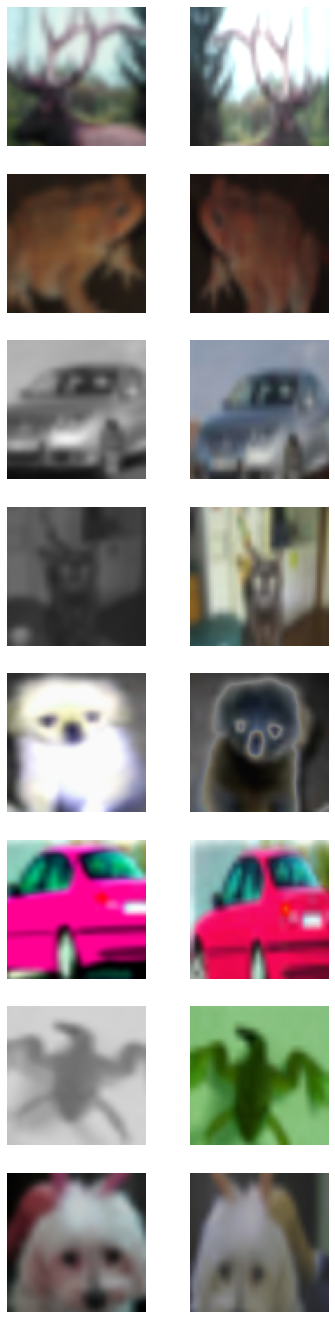

In [25]:
#In this cell we display the augmentations used. 
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=3)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#aug_pipelines = get_barlow_twins_
#aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#aug_pipelines = get_barlow_twins_aug_pipelines(size=32, rotate=True, jitter=True, bw=False, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=90, jitter_s=0.7, blur_s=(4, 8), same_on_batch=False, flip_p=0.5, rotate_p=0.5, jitter_p=0.5, bw_p=1.0, blur_p=0.5, cuda=True, xtra_tfms=[])


#old
#aug_pipelines = get_barlow_twins_aug_pipelines(size=size,bw=True, rotate=True, jitter=True, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=60, jitter_s=0.7, blur_s=(2, 4), same_on_batch=False,bw_p=0.25, flip_p=0.5, rotate_p=1.0, jitter_p=1.0, blur_p=1.0, cuda=True, xtra_tfms=[])

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,bw=True, rotate=False, jitter=True, blur=True,solar=True,resize_scale=(0.15, 1.0), rotate_deg=60, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,bw_p=0.2, flip_p=0.5, rotate_p=0.5, jitter_p=0.8, blur_p=1.0,sol_p=0.0,stats=cifar_stats,same_on_batch=False, cuda=(device=='cuda'), xtra_tfms=[])
aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,bw=True, rotate=False, jitter=True, blur=True,solar=True,resize_scale=(0.15, 1.0), rotate_deg=60, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,bw_p=0.2, flip_p=0.5, rotate_p=0.5, jitter_p=0.8, blur_p=0.1,sol_p=0.2,stats=cifar_stats,same_on_batch=False, cuda=(device=='cuda'), xtra_tfms=[])
aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines,n_in=3, print_augs=True)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=8)